In [4]:
import os

from mne.io import Raw

import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds
from brainflow.data_filter import DataFilter
import argparse
import mne
import yasa
import os
import matplotlib.pyplot as plt

%matplotlib inline
%reload_ext autoreload
%autoreload 2
        

In [13]:
output_dir = "C:\\dev\\play\\brainwave-data\\08-07-2024--22-51-16"
input_file = os.path.join(output_dir, "raw.fif")

In [14]:
raw = mne.io.read_raw_fif(input_file, preload=True)
input_file_without_ext = os.path.splitext(input_file)[0]


Opening raw data file C:\dev\play\brainwave-data\08-07-2024--22-51-16\raw.fif...
Isotrak not found
    Range : 0 ... 2327852 =      0.000 ...  9311.408 secs
Ready.
Reading 0 ... 2327852  =      0.000 ...  9311.408 secs...


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\graha\AppData\Local\Temp\ipykernel_21188\128980198.py:5: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.plot_psd(average=False).savefig(input_file_without_ext + '.pre_filter_psd_plot.png', dpi=300)
C:\Users\graha\AppData\Local\Temp\ipykernel_21188\128980198.py:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(average=False).savefig(input_file_without_ext + '.pre_filter_psd_plot.png', dpi=300)
C:\dev\play\brainwave-processor\venv\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 2751 samples (11.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

NOTE: plot_psd() is

C:\Users\graha\AppData\Local\Temp\ipykernel_21188\128980198.py:14: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  filtered.plot_psd(average=False).savefig(input_file_without_ext + '.post_filter_psd_plot.png', dpi=300)
C:\Users\graha\AppData\Local\Temp\ipykernel_21188\128980198.py:14: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered.plot_psd(average=False).savefig(input_file_without_ext + '.post_filter_psd_plot.png', dpi=300)
C:\dev\play\brainwave-processor\venv\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


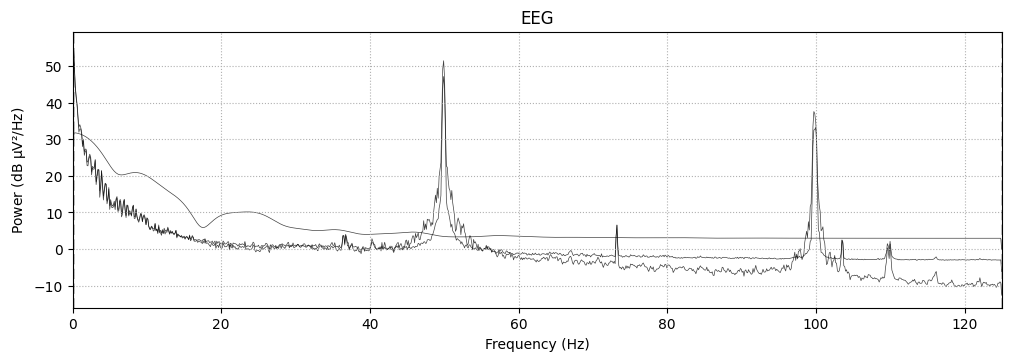

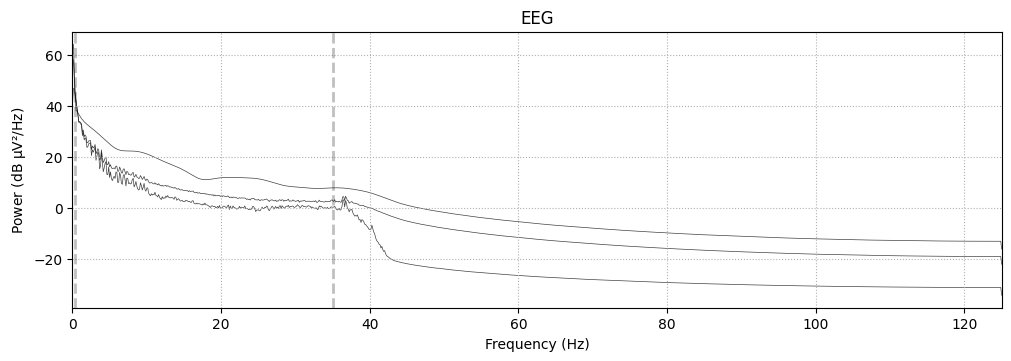

In [15]:
channels = raw.info['ch_names']
sfreq = raw.info['sfreq']
start_date = raw.info['meas_date']

raw.plot_psd(average=False).savefig(input_file_without_ext + '.pre_filter_psd_plot.png', dpi=300)

filtered = raw.copy()

# AASM recommendation
filtered.filter(0.3, 35)

filtered.notch_filter(freqs=[50,100])

filtered.plot_psd(average=False).savefig(input_file_without_ext + '.post_filter_psd_plot.png', dpi=300)

data = filtered.get_data(units="uV")


In [20]:
from run_yasa import get_sleep_stages
from functools import reduce

all_dfs = []

for i, channel in enumerate(channels):
    df_pred_ch = get_sleep_stages(filtered, data, channels, channel, sfreq);
    out = input_file_without_ext + f'.sleep_stages.{channel}.filtered.csv'
    df_pred_ch.to_csv(out, index=False)
    df_pred_ch.columns = [f"{channel}_{col}" if col not in ['Epoch'] else col for col in df_pred_ch.columns]
    all_dfs.append(df_pred_ch)

df = pd.concat(all_dfs, ignore_index=True)
df = reduce(lambda left, right: pd.merge(left, right, on='Epoch', how='outer'), all_dfs)


C:\dev\play\brainwave-processor\venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\dev\play\brainwave-processor\venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\dev\play\brainwave-processor\venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1

In [25]:
# Initialize new columns
df['Stage'] = None
df['Confidence'] = 0.0
df['Source'] = None

# Iterate through each row to find the channel with the highest confidence
for index, row in df.iterrows():
    highest_confidence = 0
    selected_channel = None
    selected_stage = None
    for channel in channels:
        confidence_col = f"{channel}_Confidence"
        stage_col = f"{channel}_Stage"
        if row[confidence_col] > highest_confidence:
            highest_confidence = row[confidence_col]
            selected_channel = channel
            selected_stage = row[stage_col]
    df.at[index, 'Stage'] = selected_stage
    df.at[index, 'Confidence'] = highest_confidence
    df.at[index, 'Source'] = selected_channel

df['EpochTime'] = (df['Epoch'] * 30) + start_date.timestamp()
df['Timestamp'] = pd.to_datetime(df['EpochTime'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Europe/London')
df.drop('EpochTime', axis=1, inplace=True)
df['StageInt'] = yasa.hypno_str_to_int(df['Stage']) # Convert "W" to 0, "N1" to 1, etc

# Reorder df
cols_to_start = ['Stage', 'Confidence', 'Epoch', 'Timestamp', 'Source']
remaining_cols = [col for col in df.columns if col not in cols_to_start]
new_col_order = cols_to_start + remaining_cols
df = df[new_col_order]

display(df)

,Stage,Confidence,Epoch,Timestamp,Source,F8-M1_Stage,F8-M1_Confidence,T4-M1_Stage,T4-M1_Confidence,O2-M1_Stage,O2-M1_Confidence,StageInt
0,W,0.999244,0,2024-07-08 22:51:16.763590097+01:00,F8-M1,W,0.999244,W,0.998636,W,0.995555,0
1,W,0.999737,1,2024-07-08 22:51:46.763590097+01:00,F8-M1,W,0.999737,W,0.999098,W,0.863641,0
2,W,0.999271,2,2024-07-08 22:52:16.763590097+01:00,F8-M1,W,0.999271,W,0.999259,W,0.733216,0
3,W,0.999595,3,2024-07-08 22:52:46.763590097+01:00,T4-M1,W,0.999444,W,0.999595,W,0.799655,0
4,W,0.999860,4,2024-07-08 22:53:16.763590097+01:00,T4-M1,W,0.998986,W,0.999860,W,0.538582,0
...,...,...,...,...,...,...,...,...,...,...,...,...
305,W,0.754090,305,2024-07-09 01:23:46.763590097+01:00,O2-M1,R,0.538483,R,0.533963,W,0.754090,0
306,R,0.461650,306,2024-07-09 01:24:16.763590097+01:00,F8-M1,R,0.461650,W,0.396924,N3,0.347592,4
307,W,0.690704,307,2024-07-09 01:24:46.763590097+01:00,O2-M1,W,0.541227,W,0.663052,W,0.690704,0
308,W,0.818783,308,2024-07-09 01:25:16.763590097+01:00,T4-M1,W,0.752657,W,0.818783,W,0.367299,0


C:\dev\play\brainwave-processor\venv\Lib\site-packages\yasa\plotting.py:89: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  freq_str = pd.tseries.frequencies.to_offset(pd.Timedelta(1 / sf_hypno, "S")).freqstr


<Axes: xlabel='Time [hrs]', ylabel='Stage'>

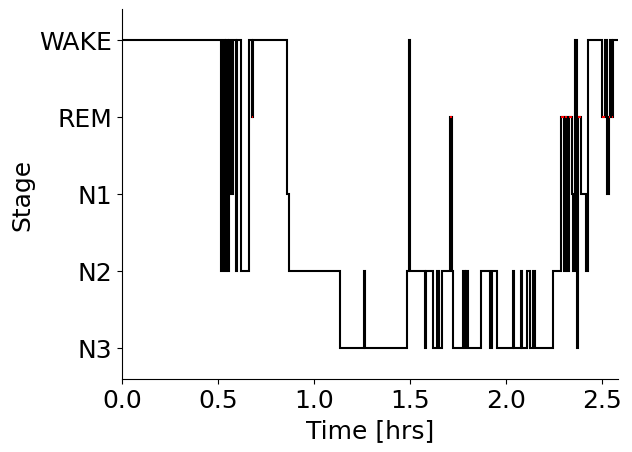

In [26]:
yasa.plot_hypnogram(df['StageInt'])